In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from monai.utils import first, set_determinism
from monai.data import Dataset, DataLoader
from monai.inferers import sliding_window_inference
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import SimpleITK as sitk


### 결과 저장

In [2]:
output_folder = '/workspace/assignment/2024/0612_v.2.5/'
if output_folder not in os.listdir('/workspace/assignment/2024'):
    os.mkdir(output_folder)

### gpu 설정

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# DATASET

In [4]:
clinical_pd = pd.read_csv('/workspace/DATA/UCSF-PDGM-v3/UCSF-PDGM-metadata_v2.csv')
values_to_remove = ['UCSF-PDGM-289', 'UCSF-PDGM-181', 'UCSF-PDGM-138', 'UCSF-PDGM-175', 'UCSF-PDGM-278', 'UCSF-PDGM-315','UCSF-PDGM-169']
clinical_pd = clinical_pd[~clinical_pd['ID'].isin(values_to_remove)]
clinical_pd = clinical_pd.reset_index(drop=True)
root_folder = '/workspace/DATA/UCSF-PDGM-v3/'

In [5]:
clinical_pd

,ID,Sex,Age at MRI,WHO CNS Grade,Final pathologic diagnosis (WHO 2021),MGMT status,MGMT index,1p/19q,IDH,1-dead 0-alive,OS,EOR,Biopsy prior to imaging,BraTS21 ID,BraTS21 Segmentation Cohort,BraTS21 MGMT Cohort
0,UCSF-PDGM-004,M,66,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,1303.0,STR,No,BraTS2021_00097,Training,Training
1,UCSF-PDGM-005,F,80,4,"Glioblastoma, IDH-wildtype",indeterminate,NaN,NaN,wildtype,1,274.0,biopsy,No,NaN,NaN,NaN
2,UCSF-PDGM-007,M,70,4,"Glioblastoma, IDH-wildtype",indeterminate,NaN,NaN,wildtype,1,417.0,STR,No,BraTS2021_00103,Training,NaN
3,UCSF-PDGM-008,M,70,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,185.0,STR,No,NaN,NaN,NaN
4,UCSF-PDGM-009,F,68,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,389.0,STR,No,BraTS2021_00049,Training,Training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,UCSF-PDGM-537,M,64,4,"Glioblastoma, IDH-wildtype",positive,16.0,intact,wildtype,0,334.0,biopsy,Yes,NaN,NaN,NaN
490,UCSF-PDGM-538,F,41,4,"Glioblastoma, IDH-wildtype",negative,0.0,intact,wildtype,0,287.0,GTR,No,NaN,NaN,NaN
491,UCSF-PDGM-539,M,72,4,"Glioblastoma, IDH-wildtype",positive,12.0,intact,wildtype,0,291.0,GTR,No,NaN,NaN,NaN
492,UCSF-PDGM-540,F,70,2,"Oligodendroglioma, IDH-mutant, 1p/19q-codeleted",positive,17.0,Co-deletion,IDH1 p.R132H,0,215.0,STR,No,NaN,NaN,NaN


In [6]:
#clinical data Sex M=0, F=1
#change clinical_pd['Sex'] to 0, 1
# binary로 변경하기 
clinical_pd['Sex'] = clinical_pd['Sex'].replace({'M': 0, 'F': 1})
clinical_pd

,ID,Sex,Age at MRI,WHO CNS Grade,Final pathologic diagnosis (WHO 2021),MGMT status,MGMT index,1p/19q,IDH,1-dead 0-alive,OS,EOR,Biopsy prior to imaging,BraTS21 ID,BraTS21 Segmentation Cohort,BraTS21 MGMT Cohort
0,UCSF-PDGM-004,0,66,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,1303.0,STR,No,BraTS2021_00097,Training,Training
1,UCSF-PDGM-005,1,80,4,"Glioblastoma, IDH-wildtype",indeterminate,NaN,NaN,wildtype,1,274.0,biopsy,No,NaN,NaN,NaN
2,UCSF-PDGM-007,0,70,4,"Glioblastoma, IDH-wildtype",indeterminate,NaN,NaN,wildtype,1,417.0,STR,No,BraTS2021_00103,Training,NaN
3,UCSF-PDGM-008,0,70,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,185.0,STR,No,NaN,NaN,NaN
4,UCSF-PDGM-009,1,68,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,389.0,STR,No,BraTS2021_00049,Training,Training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,UCSF-PDGM-537,0,64,4,"Glioblastoma, IDH-wildtype",positive,16.0,intact,wildtype,0,334.0,biopsy,Yes,NaN,NaN,NaN
490,UCSF-PDGM-538,1,41,4,"Glioblastoma, IDH-wildtype",negative,0.0,intact,wildtype,0,287.0,GTR,No,NaN,NaN,NaN
491,UCSF-PDGM-539,0,72,4,"Glioblastoma, IDH-wildtype",positive,12.0,intact,wildtype,0,291.0,GTR,No,NaN,NaN,NaN
492,UCSF-PDGM-540,1,70,2,"Oligodendroglioma, IDH-mutant, 1p/19q-codeleted",positive,17.0,Co-deletion,IDH1 p.R132H,0,215.0,STR,No,NaN,NaN,NaN


In [7]:
from sklearn.model_selection import train_test_split
#495명
# clinical_pd 데이터프레임을 train, valid, test로 나누기
train_pd, valid_pd = train_test_split(clinical_pd, test_size=0.3,stratify = clinical_pd['1-dead 0-alive'], random_state=27) 

# 인덱스 리셋
train_pd.reset_index(drop=True, inplace=True)
valid_pd.reset_index(drop=True, inplace=True)


In [8]:
valid_pd

,ID,Sex,Age at MRI,WHO CNS Grade,Final pathologic diagnosis (WHO 2021),MGMT status,MGMT index,1p/19q,IDH,1-dead 0-alive,OS,EOR,Biopsy prior to imaging,BraTS21 ID,BraTS21 Segmentation Cohort,BraTS21 MGMT Cohort
0,UCSF-PDGM-121,0,56,4,"Glioblastoma, IDH-wildtype",negative,0.0,intact,wildtype,1,879.0,GTR,No,NaN,NaN,NaN
1,UCSF-PDGM-038,0,78,4,"Glioblastoma, IDH-wildtype",positive,16.0,NaN,wildtype,1,152.0,STR,No,BraTS2021_00082,Validation,Validation
2,UCSF-PDGM-475,1,31,2,"Astrocytoma, IDH-mutant",NaN,NaN,intact,IDH1 p.R132H,0,1369.0,GTR,No,NaN,NaN,NaN
3,UCSF-PDGM-095,1,62,4,"Glioblastoma, IDH-wildtype",positive,13.0,NaN,wildtype,1,777.0,STR,No,BraTS2021_00046,Training,Training
4,UCSF-PDGM-033,0,37,4,"Glioblastoma, IDH-wildtype",positive,10.0,NaN,wildtype,1,1489.0,STR,No,BraTS2021_00070,Training,Training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,UCSF-PDGM-535,0,19,3,"Oligodendroglioma, IDH-mutant, 1p/19q-codeleted",NaN,NaN,relative co-deletion,IDH1 p.R132H,0,749.0,GTR,No,NaN,NaN,NaN
145,UCSF-PDGM-279,0,60,4,"Glioblastoma, IDH-wildtype",positive,12.0,intact,wildtype,0,163.0,STR,No,NaN,NaN,NaN
146,UCSF-PDGM-066,1,38,4,"Glioblastoma, IDH-wildtype",NaN,NaN,intact,wildtype,0,1913.0,biopsy,No,BraTS2021_01035,Training,NaN
147,UCSF-PDGM-397,0,81,4,"Glioblastoma, IDH-wildtype",positive,9.0,intact,wildtype,1,19.0,GTR,No,BraTS2021_00690,Training,Training


In [9]:
print(train_pd.shape, valid_pd.shape)


(345, 16) (149, 16)


In [10]:

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Resized,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
    # SpatialCropd,
    SpatialCrop
)

from monai.config import print_config
from monai.metrics import DiceMetric

In [11]:
from monai.transforms.compose import Transform, MapTransform
# min max normalization
class MinMax(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] -= np.min(d[key])
            d[key] /= np.max(d[key])
        return d

In [12]:
num_samples = 1
IMAGE_SIZE = (128,128,64) #original 240 240 155
#image size로 이미지 사이즈 통일
# min max normalization 
# random seed에 따라서 이미지 flip , intensity value 변경 : train의 경우만 해당. 
train_transforms = Compose(
    [
        LoadImaged(keys=["image"], ensure_channel_first=True),
        Resized(keys=["image"], spatial_size=(IMAGE_SIZE), mode=['trilinear']),
        MinMax(keys=['image']),
        Orientationd(keys=["image"], axcodes="RAS"), #RAS(Right-Anterior-Superior)로 조정
        EnsureTyped(keys=["image"], device=device, track_meta=False), #데이터 타입 확인
        RandFlipd(
            keys=["image"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandShiftIntensityd( #이미지 intensity 10%
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image"], ensure_channel_first=True),
        Resized(keys=["image"], spatial_size=(IMAGE_SIZE), mode=['trilinear']),
        MinMax(keys=['image']),
        Orientationd(keys=["image"], axcodes="RAS"),
        EnsureTyped(keys=["image"], device=device, track_meta=True),
    ]
)

In [13]:
#Dataset
#load pandas dataframe and images
# pandas에서 해당 clinical feature 가져오기 및 이미지 가져오기 , 생존 예측에 필요한 death 여부 및 생존 시간 가져오기
class Dataset(Dataset):
    def __init__(self, pd, root_dir, transform=None):
        self.pd = pd
        self.root_dir = root_dir
        self.transform = transform
        # self.target_size = target_size
        
        
    def __len__(self):
        return len(self.pd)
    def __getitem__(self, idx):
        # print(self.pd.iloc[idx, 'PatientID'])
        patient_id = self.pd.iloc[0, self.pd.columns.get_loc('ID')] #ucsf-pdgm-001
        #change patient id : ucsf-pdgm-001 to ucsf-pdgm-0001
        # patient_id에서 숫자 부분만 추출하여 새로운 형식으로 포맷
        patient_id = 'UCSF-PDGM-' + f"{int(self.pd.iloc[0, self.pd.columns.get_loc('ID')].split('-')[-1]):04d}"

        img_name = os.path.join(self.root_dir, patient_id+'_nifti', patient_id+'_FLAIR_bias.nii.gz')
        # print(img_name)
        age = self.pd.iloc[idx, self.pd.columns.get_loc('Age at MRI')]
        sex = self.pd.iloc[idx, self.pd.columns.get_loc('Sex')]
        grade = self.pd.iloc[idx, self.pd.columns.get_loc('WHO CNS Grade')]
        #concat age, sex , grade to feature
        features = np.array([age,sex, grade])
        seed = 42 + idx
    
        output = {'image': img_name, 'clinical_features': features, 'event': self.pd.iloc[idx, self.pd.columns.get_loc('1-dead 0-alive')] ,'time' : self.pd.iloc[idx, self.pd.columns.get_loc('OS')]}
        if self.transform:
                torch.manual_seed(seed)
                # image = self.resize_image(image)
                output = self.transform(output)
                # torch.manual_seed(seed)
            
        return output 


In [14]:
valid_dataset = Dataset(valid_pd, root_folder, transform=val_transforms)
valid_dataset[3] #잘 구성되어있는 체크

{'image': metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
          

In [15]:
# from matplotlib import image


# valid_dataset = Dataset(valid_pd, root_folder, transform=val_transforms)
# test_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

# 이미지 잘 불러오는지 저장해서 체크
# for i, data in enumerate(test_loader, 0):
#     inputs, labels= data['image'], data['label']
#     input_image = sitk.GetImageFromArray(inputs.cpu().squeeze().numpy())
#     label_image = sitk.GetImageFromArray(labels.cpu().squeeze().numpy())
#     print(inputs.shape)
#     print(sitk.GetArrayFromImage(input_image).shape)
#     sitk.WriteImage(input_image, output_folder+f'input_image_{i}.nii.gz')
#     sitk.WriteImage(label_image, output_folder+f'label_image_{i}.nii.gz')
#     break
    
        

In [16]:
# import nibabel as nib
#다른 함수로도 다시 한번 체크
# for i, data in enumerate(test_loader, 0):
#     inputs, labels = data['image'], data['label']
    
#     # numpy 배열로 변환
#     input_array = inputs.cpu().squeeze().numpy()
#     label_array = labels.cpu().squeeze().numpy()
    
#     # NIfTI 이미지 생성
#     input_nifti = nib.Nifti1Image(input_array, affine=np.eye(4))
#     label_nifti = nib.Nifti1Image(label_array, affine=np.eye(4))
    
#     # 디버깅용 출력
#     print(inputs.shape)
#     print(input_array.shape)
    
#     # 이미지 저장
#     nib.save(input_nifti, output_folder + f'nib_input_image_{i}.nii.gz')
#     nib.save(label_nifti, output_folder + f'nib_label_image_{i}.nii.gz')
    
#     break  # 첫 번째 배치만 처리


# UNET

https://github.com/lee-zq/3DUNet-Pytorch/tree/master/models

In [21]:
"""
3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation
Paper URL: https://arxiv.org/abs/1606.06650
Author: Amir Aghdam
"""
#해당 github에서 코드 가져와서 원하는 모델로 추가 변경 및 surv_mlp 부분 추가 
from torch import nn
# from torchsummary import summary
import torch
import time



class Conv3DBlock(nn.Module):
    """
    The basic block for double 3x3x3 convolutions in the analysis path
    -- __init__()
    :param in_channels -> number of input channels
    :param out_channels -> desired number of output channels
    :param bottleneck -> specifies the bottlneck block
    -- forward()
    :param input -> input Tensor to be convolved
    :return -> Tensor
    """

    def __init__(self, in_channels, out_channels, bottleneck = False) -> None:
        super(Conv3DBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels= in_channels, out_channels=out_channels//2, kernel_size=(3,3,3), padding=1)
        self.bn1 = nn.BatchNorm3d(num_features=out_channels//2)
        self.conv2 = nn.Conv3d(in_channels= out_channels//2, out_channels=out_channels, kernel_size=(3,3,3), padding=1)
        self.bn2 = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.bottleneck = bottleneck
        if not bottleneck:
            self.pooling = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)

    
    def forward(self, input):
        res = self.relu(self.bn1(self.conv1(input)))
        res = self.relu(self.bn2(self.conv2(res)))
        out = None
        if not self.bottleneck:
            out = self.pooling(res)
        else:
            out = res
        return out, res




class UpConv3DBlock(nn.Module):
    """
    The basic block for upsampling followed by double 3x3x3 convolutions in the synthesis path
    -- __init__()
    :param in_channels -> number of input channels
    :param out_channels -> number of residual connections' channels to be concatenated
    :param last_layer -> specifies the last output layer
    :param num_classes -> specifies the number of output channels for dispirate classes
    -- forward()
    :param input -> input Tensor
    :param residual -> residual connection to be concatenated with input
    :return -> Tensor
    """

    def __init__(self, in_channels, res_channels=0, last_layer=False, num_classes=None) -> None:
        super(UpConv3DBlock, self).__init__()
        assert (last_layer==False and num_classes==None) or (last_layer==True and num_classes!=None), 'Invalid arguments'
        self.upconv1 = nn.ConvTranspose3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(2, 2, 2), stride=2)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm3d(num_features=in_channels//2)
        self.conv1 = nn.Conv3d(in_channels=in_channels+res_channels, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.conv2 = nn.Conv3d(in_channels=in_channels//2, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.last_layer = last_layer
        if last_layer:
            self.conv3 = nn.Conv3d(in_channels=in_channels//2, out_channels=num_classes, kernel_size=(1,1,1))
            
        
    def forward(self, input, residual=None):
        out = self.upconv1(input)
        if residual!=None: out = torch.cat((out, residual), 1)
        out = self.relu(self.bn(self.conv1(out)))
        out = self.relu(self.bn(self.conv2(out)))
        if self.last_layer: out = self.conv3(out)
        return out
        
class surv_mlp(nn.Module):
    def __init__(self, in_features, out_features) -> None:
        super(surv_mlp, self).__init__()
        self.fc1 = nn.Linear(in_features, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        out = self.relu(self.fc1(input))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.relu(self.fc3(out))
        out = self.dropout(out)
        out = self.relu(self.fc4(out))
        out = self.dropout(out) 
        out = self.fc5(out)
        out = self.sigmoid(out)
        return out

    
 

class UNet3D(nn.Module):
    """
    The 3D UNet model
    -- __init__()
    :param in_channels -> number of input channels
    :param num_classes -> specifies the number of output channels or masks for different classes
    :param level_channels -> the number of channels at each level (count top-down)
    :param bottleneck_channel -> the number of bottleneck channels 
    :param device -> the device on which to run the model
    -- forward()
    :param input -> input Tensor
    :return -> Tensor
    """
    
    def __init__(self, in_channels, num_classes, level_channels=[64, 128, 256], bottleneck_channel=512) -> None:
        super(UNet3D, self).__init__()
        level_1_chnls, level_2_chnls, level_3_chnls = level_channels[0], level_channels[1], level_channels[2]
        self.a_block1 = Conv3DBlock(in_channels=in_channels, out_channels=level_1_chnls)
        self.a_block2 = Conv3DBlock(in_channels=level_1_chnls, out_channels=level_2_chnls)
        self.a_block3 = Conv3DBlock(in_channels=level_2_chnls, out_channels=level_3_chnls)
        self.bottleNeck = Conv3DBlock(in_channels=level_3_chnls, out_channels=bottleneck_channel)
        #
        self.bottleNeck2 = Conv3DBlock(in_channels=bottleneck_channel, out_channels=bottleneck_channel)
        self.bottleNeck3 = Conv3DBlock(in_channels=bottleneck_channel, out_channels=bottleneck_channel)
        self.bottleNeck4 = Conv3DBlock(in_channels=bottleneck_channel, out_channels=bottleneck_channel, bottleneck= True)
        self.surv_mlp = surv_mlp(2051,1)

    
    def forward(self, input, clinical_features):
        #Analysis path forward feed
        out, residual_level1 = self.a_block1(input)
        out, residual_level2 = self.a_block2(out)
        out, residual_level3 = self.a_block3(out)
        out, _ = self.bottleNeck(out)
        surv_out, _ = self.bottleNeck2(out) #torch.Size([2, 512, 8, 8, 4]) torch.Size([2, 512, 16, 16, 8])
        surv_out2,_ = self.bottleNeck3(surv_out) #torch.Size([2, 512, 4, 4, 2]) torch.Size([2, 512, 8, 8, 4])
        surv_out3,_ = self.bottleNeck4(surv_out2) #torch.Size([2, 512, 2, 2, 1]) torch.Size([2, 512, 4, 4, 2])
        surv_out3 = surv_out3.squeeze(-1) #torch.Size([2, 512, 2, 2])
        surv_out3 = surv_out3.reshape(surv_out3.size(0), -1) #torch.Size([2, 2048])
        surv_out3 = torch.cat((surv_out3,clinical_features),1)
        risk_score = self.surv_mlp(surv_out3)

        return risk_score


In [22]:
input_size =(2,1, 128, 128, 64)  # Example: (batch, channels, depth, height, width)
clinical = (2,3)
model = UNet3D(in_channels=1, num_classes=1)
x = torch.rand(input_size)
y=  torch.rand(clinical)
# grade_score, risk_score = model(x,y)
risk_score = model(x,y)

print(f"Input size: {input_size}")
print(f"Output size: {risk_score.size()}")
# print(f"risk_score size: {risk_score.size()}")
# print(risk_score)


Input size: (2, 1, 128, 128, 64)
Output size: torch.Size([2, 1])


In [23]:
class NegativeLogLikelihood(nn.Module): #낮을 수록 좋은것.  # cox negative partial log-likelihood loss 함수 
    def __init__(self, l2_reg=0.1):
        super().__init__()
        if l2_reg is not None:
            self.is_reg = True
            self.reg = Regularization(order=2, weight_decay=l2_reg)
        else:
            self.is_reg = False

    def forward(self, risk_pred, censor, y, device, model):
        # e = 1.-censor
        e = censor
        mask = torch.ones(y.shape[0], y.shape[0]).to(device, dtype=torch.float)
        mask[(y.T - y) > 0] = 0
        log_loss = torch.exp(risk_pred) * mask
        log_loss = torch.sum(log_loss, dim=0) / torch.sum(mask, dim=0)
        log_loss = torch.log(log_loss).reshape(-1, 1)
        neg_log_loss = -torch.sum((risk_pred-log_loss) * e)
        neg_log_loss = neg_log_loss / (torch.sum(e) + 1e-6)
        if self.is_reg:
            l2_loss = self.reg(model)
            neg_log_loss = neg_log_loss + l2_loss
        return neg_log_loss
    
    
class Regularization(object):
    def __init__(self, order, weight_decay):
        ''' The initialization of Regularization class
        :param order: (int) norm order number
        :param weight_decay: (float) weight decay rate
        '''
        super(Regularization, self).__init__()
        self.order = order
        self.weight_decay = weight_decay

    def __call__(self, model):
        ''' Performs calculates regularization(self.order) loss for model.
        :param model: (torch.nn.Module object)
        :return reg_loss: (torch.Tensor) the regularization(self.order) loss
        '''
        reg_loss = 0
        for name, w in model.named_parameters():
            #if 'weight' in name:
            reg_loss = reg_loss + torch.norm(w, p=self.order)
        reg_loss = self.weight_decay * reg_loss
        return reg_loss


# TRAIN

In [24]:
from lifelines.utils import concordance_index
from datetime import datetime
from monai.data import DataLoader, pad_list_data_collate
from lifelines.statistics import logrank_test
from monai.metrics import DiceMetric
from torch.nn.utils import clip_grad_norm_

In [25]:
import monai
#모델 선언 및 loss 선언 
model = UNet3D(in_channels=1, num_classes=1)
criterion= NegativeLogLikelihood().to(device)  # For risk score

model.to(device)


UNet3D(
  (a_block1): Conv3DBlock(
    (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (a_block2): Conv3DBlock(
    (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, 

In [28]:
from numpy import test
from lifelines.utils import concordance_index
from datetime import datetime
from monai.data import DataLoader, pad_list_data_collate
from lifelines.statistics import logrank_test
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import f1_score
from lifelines import KaplanMeierFitter

# 모델 학습 및 test set에 대한 결과 출력하기 epoch마다 
optimizer = optim.Adam(model.parameters(), lr=1e-7)  # 전체 모델 파라미터

def train(device):
    min_train_loss= 999
    torch.autograd.set_detect_anomaly(True)
    num_epochs = 100
    best_model_result=0.5
    start_time = datetime.now()
    train_dataset = Dataset(train_pd, root_folder, transform=train_transforms)
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
    valid_dataset = Dataset(valid_pd, root_folder, transform=val_transforms)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
    train_loss_list = [0] * num_epochs
    test_loss_list = [0] * num_epochs
    c_index_train_list = [0] * num_epochs
    c_index_test_list = [0] * num_epochs
    p_value_train_list = [0] * num_epochs
    p_value_test_list = [0] * num_epochs
    best_model_epoch=[]
    median_risk_list= [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_seg_loss = 0.0
        train_surv_loss = 0.0
        surv_y_true =[]
        surv_y_pred = []
        event_list=[]
        for  data in train_loader:
            inputs, clinical_features, event, time = data['image'], data['clinical_features'], data['event'], data['time']
            inputs, clinical_features= inputs.to(device), clinical_features.to(device)
            event, time = event.to(device), time.to(device)
            event = event.reshape(-1,1)
            time = time.reshape(-1,1)
            optimizer.zero_grad()
            risk_score = model(inputs, clinical_features)
            risk_score = risk_score.reshape(-1,1)
            # loss = criterion()
            loss = criterion(risk_score, event, time, device, model)
            loss.backward()
            clip_grad_norm_(model.parameters(), 10)
            optimizer.step()
            train_loss += loss.item()
            surv_y_true.extend(time.cpu().numpy())
            event_list.extend(event.cpu().numpy())
            surv_y_pred.extend(risk_score.cpu().detach().numpy())
        try:
            train_c_index = concordance_index(surv_y_true, -np.array(surv_y_pred), event_list) 
        except ValueError as e:
            print("NaN values detected. Skipping calculation of concordance index.")
            train_c_index=0
            # break
        except ZeroDivisionError:
            train_c_index=0
        event_list = [int(arr[0]) for arr in event_list]
        surv_y_true =[float(arr[0]) for arr in surv_y_true]
        y_pred =[float(arr[0]) for arr in surv_y_pred]
        train_df = pd.DataFrame({'risk_score':y_pred,'time':surv_y_true,'event':event_list})
        df_sorted = train_df.sort_values(by='risk_score')
        half = len(df_sorted) // 2
        df_1 = df_sorted.iloc[:half]
        df_2 = df_sorted.iloc[half:]
        median_risk = df_sorted.iloc[half]['risk_score']
        print(f"median risk: {median_risk}")
        train_log = logrank_test(df_1['time'],df_2['time'], df_1['event'], df_2['event'])
        train_loss = train_loss/len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}, C-index: {train_c_index}, pvalue :{train_log.p_value:.3f}")
        with torch.no_grad():
            model.eval()
            valid_loss =0.0
            surv_y_true =[]
            surv_y_pred = []
            event_list =[]
            for data in valid_loader:
                inputs, clinical_features, event, time = data['image'], data['clinical_features'], data['event'], data['time']
                inputs, clinical_features= inputs.to(device), clinical_features.to(device)
                event, time = event.to(device), time.to(device)
                risk_score = model(inputs, clinical_features)
                risk_score = risk_score.reshape(-1,1)
                event = event.reshape(-1,1)
                time = time.reshape(-1,1)
                loss = criterion(risk_score, event, time, device, model)
                valid_loss += loss.item()
                surv_y_true.extend(time.cpu().numpy())
                event_list.extend(event.cpu().numpy())
                surv_y_pred.extend(risk_score.cpu().detach().numpy())
            valid_loss = valid_loss/len(valid_loader)
            try:
                valid_c_index = concordance_index(surv_y_true, -np.array(surv_y_pred), event_list) 
            except ValueError as e:
                print("NaN values detected. Skipping calculation of concordance index.")
                valid_c_index=0
                # break
            except ZeroDivisionError:
                valid_c_index=0
            event_list = [int(arr[0]) for arr in event_list]
            surv_y_true =[float(arr[0]) for arr in surv_y_true]
            y_pred =[float(arr[0]) for arr in surv_y_pred]
            valid_df = pd.DataFrame({'risk_score':y_pred,'time':surv_y_true,'event':event_list})
            df_sorted = valid_df.sort_values(by='risk_score')
            df_1 = df_sorted[df_sorted['risk_score'] < median_risk]
            df_2 = df_sorted[df_sorted['risk_score'] >= median_risk]
            test_log = logrank_test(df_1['time'],df_2['time'], df_1['event'], df_2['event'])
            print(f"Valid Epoch {epoch+1}/{num_epochs}, Loss: {valid_loss}, C-index: {valid_c_index} , pvalue :{test_log.p_value:.3f}")         
        train_loss_list[epoch]= train_loss
        test_loss_list[epoch] = valid_loss
        c_index_train_list[epoch]=train_c_index
        c_index_test_list[epoch]=valid_c_index
        median_risk_list[epoch]=median_risk
        p_value_train_list[epoch]=train_log.p_value
        p_value_test_list[epoch]=test_log.p_value
        torch.save(model.state_dict(),f'{output_folder}model_{epoch}.pth')
        # print(f"Training time: {datetime.now()-start_time}")
        # print()
        if train_loss <min_train_loss and test_log.p_value < 0.05 and train_log.p_value<0.05:
            min_train_loss = train_loss
            # best_model_result = valid_c_index
            kmf = KaplanMeierFitter(alpha = 0.05)
            kmf.fit(df_1['time'], df_1['event'], label='Low risk group')
            kmf.plot()
            kmf.fit(df_2['time'], df_2['event'], label='High risk group')
            kmf.plot()        
            plt.xlabel('time')
            plt.ylabel('surv prop')
            plt.show()
            print(f"Best Model saved at epoch {epoch}, {train_c_index},{train_log.p_value:.3f}")
    print(f"Training time: {datetime.now()-start_time}")

    return train_loss_list,test_loss_list, c_index_train_list, c_index_test_list, median_risk_list, p_value_train_list, p_value_test_list

        

median risk: 0.5166363716125488
Epoch 1/100, Loss: 38.78501269575479, C-index: 0.5395162532737636, pvalue :0.071
Valid Epoch 1/100, Loss: 38.75453186035156, C-index: 0.6924540790997848 , pvalue :0.000
median risk: 0.5164600610733032
Epoch 2/100, Loss: 38.724281565348306, C-index: 0.5355107071329533, pvalue :0.039
Valid Epoch 2/100, Loss: 38.69387435913086, C-index: 0.6942743670362402 , pvalue :0.000


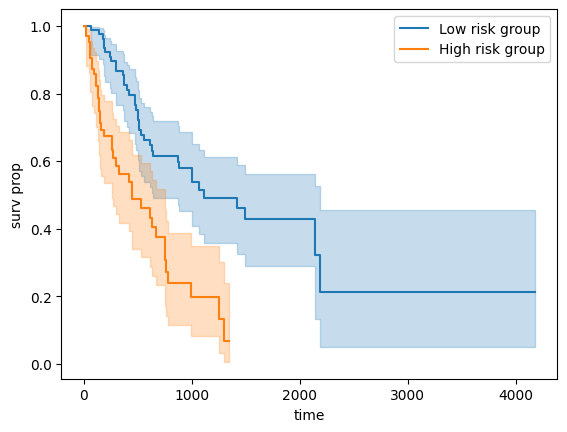

Best Model saved at epoch 1, 0.5355107071329533,0.039
median risk: 0.5156562328338623
Epoch 3/100, Loss: 38.66366193467292, C-index: 0.5367739947619781, pvalue :0.110
Valid Epoch 3/100, Loss: 38.6332893371582, C-index: 0.6929505212642727 , pvalue :0.000
median risk: 0.5159818530082703
Epoch 4/100, Loss: 38.60311875274216, C-index: 0.5425666307194578, pvalue :0.054
Valid Epoch 4/100, Loss: 38.57278823852539, C-index: 0.6932814827072646 , pvalue :0.000
median risk: 0.5158199071884155
Epoch 5/100, Loss: 38.54266287762186, C-index: 0.5395162532737636, pvalue :0.051
Valid Epoch 5/100, Loss: 38.51237487792969, C-index: 0.6929505212642727 , pvalue :0.000
median risk: 0.5161868929862976
Epoch 6/100, Loss: 38.48230019168577, C-index: 0.5378832229240487, pvalue :0.112
Valid Epoch 6/100, Loss: 38.45206832885742, C-index: 0.6904683104418335 , pvalue :0.000
median risk: 0.5148552060127258
Epoch 7/100, Loss: 38.422028815228, C-index: 0.5413957787706054, pvalue :0.263
Valid Epoch 7/100, Loss: 38.3918

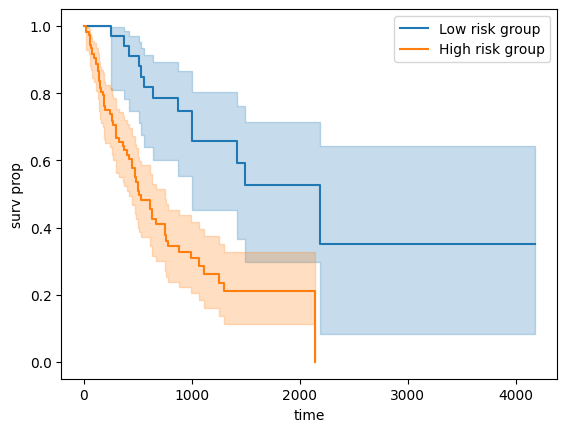

Best Model saved at epoch 7, 0.5479587120628563,0.023
median risk: 0.5156326293945312
Epoch 9/100, Loss: 38.30175157629925, C-index: 0.537605915883531, pvalue :0.085
Valid Epoch 9/100, Loss: 38.27164840698242, C-index: 0.6924540790997848 , pvalue :0.000
median risk: 0.5151161551475525
Epoch 10/100, Loss: 38.24174484031788, C-index: 0.5334463102757665, pvalue :0.149
Valid Epoch 10/100, Loss: 38.21168899536133, C-index: 0.6937779248717525 , pvalue :0.000
median risk: 0.5159318447113037
Epoch 11/100, Loss: 38.18182636205701, C-index: 0.5366507471884148, pvalue :0.193
Valid Epoch 11/100, Loss: 38.15181350708008, C-index: 0.6914611947708093 , pvalue :0.000
median risk: 0.5145070552825928
Epoch 12/100, Loss: 38.121994283924934, C-index: 0.5416114620243414, pvalue :0.052
Valid Epoch 12/100, Loss: 38.09202194213867, C-index: 0.6909647526063214 , pvalue :0.000
median risk: 0.5152066349983215
Epoch 13/100, Loss: 38.06224916983342, C-index: 0.5360961331073795, pvalue :0.066
Valid Epoch 13/100, Lo

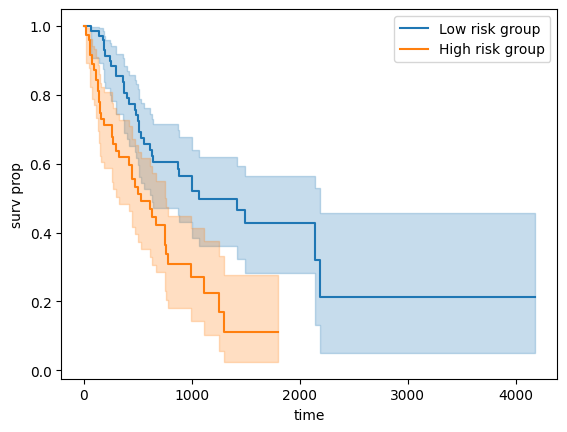

Best Model saved at epoch 13, 0.5440764134956093,0.013
median risk: 0.5153743028640747
Epoch 15/100, Loss: 37.94301588638969, C-index: 0.5438607302418733, pvalue :0.023
Valid Epoch 15/100, Loss: 37.91316604614258, C-index: 0.6909647526063214 , pvalue :0.000


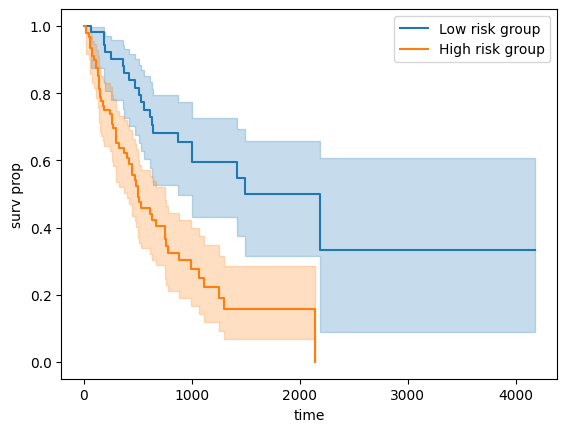

Best Model saved at epoch 14, 0.5438607302418733,0.023
median risk: 0.5151587724685669
Epoch 16/100, Loss: 37.88352725263955, C-index: 0.5392389462332461, pvalue :0.123
Valid Epoch 16/100, Loss: 37.853729248046875, C-index: 0.692123117656793 , pvalue :0.000
median risk: 0.5154695510864258
Epoch 17/100, Loss: 37.8241234931393, C-index: 0.5414574025573872, pvalue :0.054
Valid Epoch 17/100, Loss: 37.794368743896484, C-index: 0.6926195598212809 , pvalue :0.000
median risk: 0.5150208473205566
Epoch 18/100, Loss: 37.76480437568996, C-index: 0.5388692035125558, pvalue :0.034
Valid Epoch 18/100, Loss: 37.735084533691406, C-index: 0.6929505212642727 , pvalue :0.000


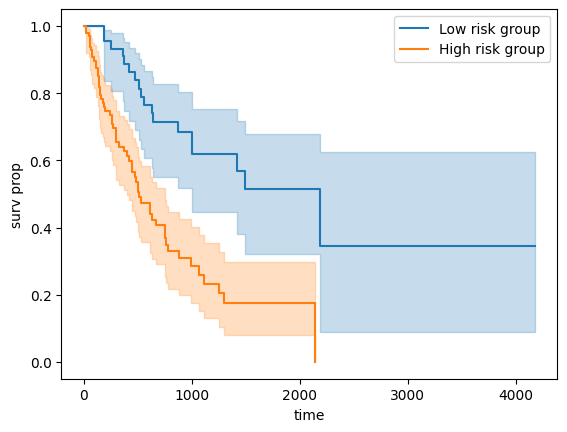

Best Model saved at epoch 17, 0.5388692035125558,0.034
median risk: 0.5156288146972656
Epoch 19/100, Loss: 37.70556978972062, C-index: 0.538437837005084, pvalue :0.072
Valid Epoch 19/100, Loss: 37.67588806152344, C-index: 0.6949362899222241 , pvalue :0.000
median risk: 0.5149458646774292
Epoch 20/100, Loss: 37.646419923201854, C-index: 0.5352334000924357, pvalue :0.099
Valid Epoch 20/100, Loss: 37.61678695678711, C-index: 0.6927850405427768 , pvalue :0.000
median risk: 0.5150085091590881
Epoch 21/100, Loss: 37.58735515207484, C-index: 0.539670312740718, pvalue :0.062
Valid Epoch 21/100, Loss: 37.557769775390625, C-index: 0.6932814827072646 , pvalue :0.000
median risk: 0.5150685906410217
Epoch 22/100, Loss: 37.528375299426095, C-index: 0.5494684948390078, pvalue :0.057
Valid Epoch 22/100, Loss: 37.498836517333984, C-index: 0.6931160019857686 , pvalue :0.000
median risk: 0.5154708623886108
Epoch 23/100, Loss: 37.46948048688363, C-index: 0.5369896780157141, pvalue :0.095
Valid Epoch 23/10

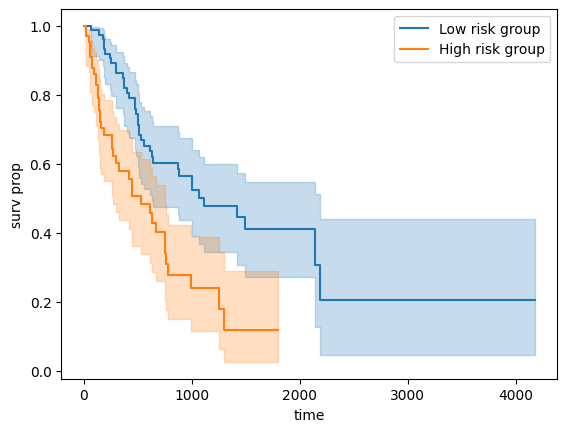

Best Model saved at epoch 30, 0.5478354644892929,0.037
median risk: 0.5137156844139099
Epoch 32/100, Loss: 36.94328789089037, C-index: 0.5400400554614081, pvalue :0.079
Valid Epoch 32/100, Loss: 36.91417694091797, C-index: 0.6972530200231672 , pvalue :0.000
median risk: 0.513819694519043
Epoch 33/100, Loss: 36.88525461390399, C-index: 0.540656293329225, pvalue :0.065
Valid Epoch 33/100, Loss: 36.85618209838867, C-index: 0.6978322025484031 , pvalue :0.000
median risk: 0.51419597864151
Epoch 34/100, Loss: 36.827308909098306, C-index: 0.5439839778154367, pvalue :0.045
Valid Epoch 34/100, Loss: 36.79827880859375, C-index: 0.6962601356941917 , pvalue :0.001


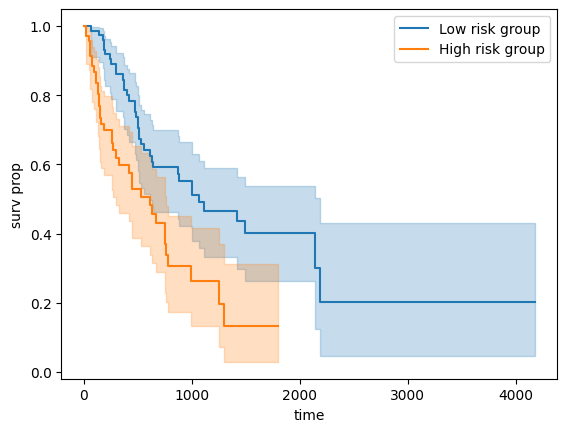

Best Model saved at epoch 33, 0.5439839778154367,0.045
median risk: 0.5136746764183044
Epoch 35/100, Loss: 36.76945082070171, C-index: 0.54047142196888, pvalue :0.178
Valid Epoch 35/100, Loss: 36.74047088623047, C-index: 0.6965910971371835 , pvalue :0.000
median risk: 0.5139864087104797
Epoch 36/100, Loss: 36.71167980691661, C-index: 0.540656293329225, pvalue :0.113
Valid Epoch 36/100, Loss: 36.682735443115234, C-index: 0.6931160019857686 , pvalue :0.000
median risk: 0.5137693285942078
Epoch 37/100, Loss: 36.653997139308764, C-index: 0.5400708673547989, pvalue :0.094
Valid Epoch 37/100, Loss: 36.62509536743164, C-index: 0.6966738374979314 , pvalue :0.001
median risk: 0.5133353471755981
Epoch 38/100, Loss: 36.59640288422073, C-index: 0.5444153443229086, pvalue :0.062
Valid Epoch 38/100, Loss: 36.56754684448242, C-index: 0.6955982128082079 , pvalue :0.000
median risk: 0.5148017406463623
Epoch 39/100, Loss: 36.53889864493107, C-index: 0.540656293329225, pvalue :0.165
Valid Epoch 39/100, L

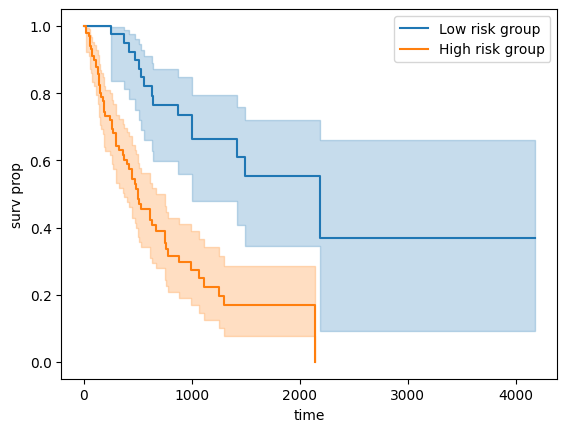

Best Model saved at epoch 41, 0.5440764134956093,0.022
median risk: 0.5140550136566162
Epoch 43/100, Loss: 36.309771695344345, C-index: 0.5441688491757819, pvalue :0.126
Valid Epoch 43/100, Loss: 36.28114318847656, C-index: 0.6924540790997848 , pvalue :0.000
median risk: 0.5132793188095093
Epoch 44/100, Loss: 36.25271579908288, C-index: 0.5412417193036512, pvalue :0.072
Valid Epoch 44/100, Loss: 36.22413635253906, C-index: 0.698245904352143 , pvalue :0.000
median risk: 0.5139487981796265
Epoch 45/100, Loss: 36.19575036090353, C-index: 0.541703897704514, pvalue :0.149
Valid Epoch 45/100, Loss: 36.1672248840332, C-index: 0.6997352308456065 , pvalue :0.000
median risk: 0.5138504505157471
Epoch 46/100, Loss: 36.13887601106063, C-index: 0.543336928054229, pvalue :0.143
Valid Epoch 46/100, Loss: 36.110389709472656, C-index: 0.6957636935297038 , pvalue :0.000
median risk: 0.5135795474052429
Epoch 47/100, Loss: 36.08209222987078, C-index: 0.5399476197812355, pvalue :0.115
Valid Epoch 47/100, L

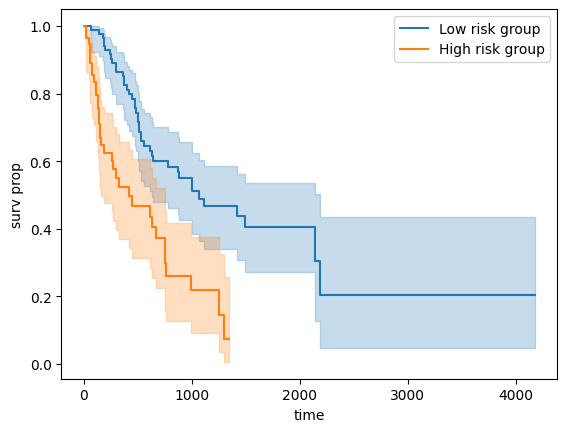

Best Model saved at epoch 66, 0.539670312740718,0.047
median risk: 0.5128579139709473
Epoch 68/100, Loss: 34.911047982478486, C-index: 0.5370513018024957, pvalue :0.059
Valid Epoch 68/100, Loss: 34.88358688354492, C-index: 0.69510177064372 , pvalue :0.000
median risk: 0.5124287605285645
Epoch 69/100, Loss: 34.856322822017944, C-index: 0.5433677399476198, pvalue :0.090
Valid Epoch 69/100, Loss: 34.82891082763672, C-index: 0.69510177064372 , pvalue :0.000
median risk: 0.5124799609184265
Epoch 70/100, Loss: 34.8016939577849, C-index: 0.5436758588815283, pvalue :0.067
Valid Epoch 70/100, Loss: 34.77433395385742, C-index: 0.6934469634287606 , pvalue :0.000
median risk: 0.5128548741340637
Epoch 71/100, Loss: 34.7471628382586, C-index: 0.543121244800493, pvalue :0.046
Valid Epoch 71/100, Loss: 34.719852447509766, C-index: 0.6941088863147443 , pvalue :0.000


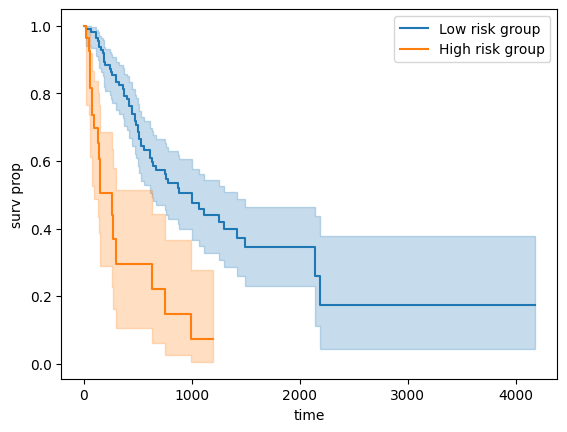

Best Model saved at epoch 70, 0.543121244800493,0.046
median risk: 0.5119547247886658
Epoch 72/100, Loss: 34.692726091025534, C-index: 0.5398243722076722, pvalue :0.232
Valid Epoch 72/100, Loss: 34.665462493896484, C-index: 0.6929505212642727 , pvalue :0.000
median risk: 0.5124219655990601
Epoch 73/100, Loss: 34.63838889080545, C-index: 0.5386843321522108, pvalue :0.381
Valid Epoch 73/100, Loss: 34.611167907714844, C-index: 0.6946053284792322 , pvalue :0.000
median risk: 0.5128557682037354
Epoch 74/100, Loss: 34.584148185840554, C-index: 0.5414574025573872, pvalue :0.074
Valid Epoch 74/100, Loss: 34.55698013305664, C-index: 0.6939434055932484 , pvalue :0.000
median risk: 0.5127574801445007
Epoch 75/100, Loss: 34.53000442947167, C-index: 0.5409644122631335, pvalue :0.279
Valid Epoch 75/100, Loss: 34.50288772583008, C-index: 0.692123117656793 , pvalue :nan
median risk: 0.511761486530304
Epoch 76/100, Loss: 34.47595742267111, C-index: 0.5426282545062394, pvalue :0.059
Valid Epoch 76/100, 

In [29]:
train_loss_list,test_loss_list, c_index_train_list, c_index_test_list, median_risk_list, p_value_train_list, p_value_test_list= train(device)
def save_list_to_txt(lst, filename):
    with open(filename, 'w') as file:
        for item in lst:
            file.write(str(item) + '\n')

# 리스트를 txt 파일로 저장
save_list_to_txt(train_loss_list, output_folder+'train_loss.txt')
save_list_to_txt(test_loss_list, output_folder+'valid_loss.txt')
save_list_to_txt(c_index_train_list, output_folder+'c_index_train.txt')
save_list_to_txt(c_index_test_list, output_folder+'c_index_test.txt')
save_list_to_txt(median_risk_list, output_folder+'median_risk.txt')
save_list_to_txt(p_value_train_list, output_folder+'p_value_train.txt')
save_list_to_txt(p_value_test_list, output_folder+'p_value_test.txt')


In [32]:
p_value_test_list[70]

6.439138720272794e-08

In [5]:
def evaluate_file(file_path): #저장한 리스트 불러오기
    result = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            line_list = eval(line.replace('nan', 'float("nan")'))
            result.append(line_list)
    return result




In [7]:
c_index_train_list = evaluate_file(output_folder+f'c_index_train.txt')
c_index_test_list = evaluate_file(output_folder+f'c_index_test.txt')
train_epoch_p = evaluate_file(output_folder+f'p_value_train.txt')
test_epoch_p = evaluate_file(output_folder+f'p_value_test.txt')
median_risk_list = evaluate_file(output_folder+f'median_risk.txt')